# Sensitive DE

In [68]:
suppressMessages({
    library(tidyverse)
    library(limma)
    library(hashmap)
    library(magrittr)
    source('../../R/gene_signature.R')
})

In [2]:
t3k.path = '../../data/assafNormedData/T3k.RData'
load(t3k.path)
t3.tree = tree
t3.normalized = normalized 

In [3]:
t4k.path = '../../data/assafNormedData/T4k.RData'
load(t4k.path)
t4.tree = tree
t4.normalized = normalized 

In [4]:
DE_hclust = function(cell_ancestor_matrix, expression_matrix, FC_thresh=1.0, q_thresh=0.2) {
    cluster_DE = c()
    for (k in seq(ncol(cell_ancestor_matrix))) {
       print(k)
       if (k == 1) {
           unique_clusters = unique(cell_ancestor_matrix[,k])
           expression = expression_matrix
           for (unique_cluster in unique_clusters) {
               unique_cluster_membership = (cell_ancestor_matrix[,k] == unique_cluster)
               over = OverExpressedGenes(unique_cluster_membership, t(expression), q_thresh, FC_thresh)
               subtree_id = paste(data.matrix(cell_ancestor_matrix[which(unique_cluster_membership)[1], seq(k)]), collapse='_')
               print(paste(subtree_id, length(over)))
               if (length(over) > 0) {
                   cluster_DE = rbind(cluster_DE, data.frame(id = subtree_id, gene=over))
               } else {
                   cluster_DE = rbind(cluster_DE, data.frame(id = subtree_id, gene=NA))
               }
           }
       } else {
       # find where the split occurs
        summary_matrix = table(cell_ancestor_matrix[,k-1], cell_ancestor_matrix[,k])
        parent_split_idx = apply(summary_matrix, 1, function(x) sum(x > 0) == 2)
        parent_split = names(parent_split_idx)[parent_split_idx]            
        # subset for the part expression matrix of the expression matrix at level k - 1 where it
        subset_idx = cell_ancestor_matrix[,k-1] == parent_split
        expression = expression_matrix[subset_idx, ]
        cell_ancestor_matrix_subset = cell_ancestor_matrix[subset_idx,]
        unique_clusters = unique(cell_ancestor_matrix_subset[,k])
        for (unique_cluster in unique_clusters) {
               unique_cluster_membership = (cell_ancestor_matrix_subset[,k] == unique_cluster)
               over = OverExpressedGenes(unique_cluster_membership, t(expression), q_thresh, FC_thresh)
               subtree_id = paste(data.matrix(cell_ancestor_matrix_subset[which(unique_cluster_membership)[1], seq(k)]), collapse='_')
               print(paste(subtree_id, length(over)))   
               if (length(over) > 0) {
                   cluster_DE = rbind(cluster_DE, data.frame(id = subtree_id, gene=over))
               } else {
                   cluster_DE = rbind(cluster_DE, data.frame(id = subtree_id, gene=NA))
               }
           }
       }
    }
    return(cluster_DE)
}

In [12]:
concatLabels = function(unique_labels) { # unique labels (n x 2) 
    label.df = unique_labels %>%
      group_by(id) %>%
      mutate(n = seq(n())) %>%
      spread(n, desc) %>%
      unite(desc, colnames(.)[-1]) %>%
      mutate(desc = sapply(desc, function(x) gsub('_NA', '', x)))
      name.map = hashmap(unique_labels$id, unique_labels$desc)
    return(label.df)
}

## Load dataset

In [30]:
t3.desc = t3.tree[, ncol(t3.tree)]
t3.id = t3.tree[,-ncol(t3.tree)]

In [37]:
head(t3.id)

vector,vector,vector,vector,vector,vector,vector,vector
1,1,1,1,1,1,1,1
1,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2
1,2,2,2,2,2,3,3
1,2,2,2,2,2,3,3
2,3,3,3,3,3,4,4


In [111]:
t4.desc = t4.tree[, ncol(t4.tree)]
t4.id = t4.tree[,-ncol(t4.tree)]

In [112]:
head(t3.id)

vector,vector,vector,vector,vector,vector,vector,vector
1,1,1,1,1,1,1,1
1,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2
1,2,2,2,2,2,3,3
1,2,2,2,2,2,3,3
2,3,3,3,3,3,4,4


## create word version of the cluster ancestor matrix

In [108]:
word_ancestor_matrix = function(id_matrix, cell_desc){
    K = seq(ncol(id_matrix))
    desc.df = c()
    for (k in K) {
        id = id_matrix[,k]
        unique_labels = data.frame(id = id, desc=cell_desc) %>% distinct()
        label.df = concatLabels(unique_labels)
        label.map = hashmap(label.df$id, label.df$desc)
        desc = sapply(id, function(x) label.map[[as.numeric(x)]])
        desc.df = cbind(desc.df, desc)
    }                
    colnames(desc.df) = K
    return(desc.df)
}

In [109]:
t3.desc.df = word_ancestor_matrix(t3.id, t3.desc)

In [110]:
head(t3.desc.df)

,1,2,3,4,5,6,7,8
1,CD4.Tfh.1_Unknown.2_CD4.Tfh.2_CD4.Th2.1_Unknown.1_CD4.Th2.2_CD4.Treg,CD4.Tfh.1_CD4.Th2.1_CD4.Treg,CD4.Tfh.1_CD4.Th2.1_CD4.Treg,CD4.Tfh.1_CD4.Th2.1_CD4.Treg,CD4.Tfh.1_CD4.Th2.1,CD4.Tfh.1_CD4.Th2.1,CD4.Tfh.1_CD4.Th2.1,CD4.Tfh.1
1,CD4.Tfh.1_Unknown.2_CD4.Tfh.2_CD4.Th2.1_Unknown.1_CD4.Th2.2_CD4.Treg,Unknown.2_CD4.Tfh.2_Unknown.1_CD4.Th2.2,Unknown.2_CD4.Tfh.2_Unknown.1_CD4.Th2.2,Unknown.2_CD4.Tfh.2,Unknown.2_CD4.Tfh.2,Unknown.2_CD4.Tfh.2,Unknown.2,Unknown.2
1,CD4.Tfh.1_Unknown.2_CD4.Tfh.2_CD4.Th2.1_Unknown.1_CD4.Th2.2_CD4.Treg,Unknown.2_CD4.Tfh.2_Unknown.1_CD4.Th2.2,Unknown.2_CD4.Tfh.2_Unknown.1_CD4.Th2.2,Unknown.2_CD4.Tfh.2,Unknown.2_CD4.Tfh.2,Unknown.2_CD4.Tfh.2,Unknown.2,Unknown.2
1,CD4.Tfh.1_Unknown.2_CD4.Tfh.2_CD4.Th2.1_Unknown.1_CD4.Th2.2_CD4.Treg,Unknown.2_CD4.Tfh.2_Unknown.1_CD4.Th2.2,Unknown.2_CD4.Tfh.2_Unknown.1_CD4.Th2.2,Unknown.2_CD4.Tfh.2,Unknown.2_CD4.Tfh.2,Unknown.2_CD4.Tfh.2,CD4.Tfh.2,CD4.Tfh.2
1,CD4.Tfh.1_Unknown.2_CD4.Tfh.2_CD4.Th2.1_Unknown.1_CD4.Th2.2_CD4.Treg,Unknown.2_CD4.Tfh.2_Unknown.1_CD4.Th2.2,Unknown.2_CD4.Tfh.2_Unknown.1_CD4.Th2.2,Unknown.2_CD4.Tfh.2,Unknown.2_CD4.Tfh.2,Unknown.2_CD4.Tfh.2,CD4.Tfh.2,CD4.Tfh.2
2,CD8.CTL.1_CD8.CTL.2,CD8.CTL.1_CD8.CTL.2,CD8.CTL.1,CD8.CTL.1,CD8.CTL.1,CD8.CTL.1,CD8.CTL.1,CD8.CTL.1


In [113]:
t4.desc.df = word_ancestor_matrix(t4.id, t4.desc)

In [114]:
head(t4.desc.df)

,1,2,3,4,5,6,7,8,9,10
1,CD4.Icos.2_CD8.1_CD4_Th1.2_CD4.Tfh.1_CD8.2_CD4.Tfh.2_CD4.Treg_CD4.Th1.1_CD4.Icos.1,CD4.Icos.2_CD8.1_CD4_Th1.2_CD4.Tfh.1_CD8.2_CD4.Icos.1,CD4.Icos.2_CD8.1_CD4_Th1.2,CD4.Icos.2_CD8.1_CD4_Th1.2,CD4.Icos.2_CD8.1_CD4_Th1.2,CD4.Icos.2_CD4_Th1.2,CD4.Icos.2_CD4_Th1.2,CD4.Icos.2,CD4.Icos.2,CD4.Icos.2
1,CD4.Icos.2_CD8.1_CD4_Th1.2_CD4.Tfh.1_CD8.2_CD4.Tfh.2_CD4.Treg_CD4.Th1.1_CD4.Icos.1,CD4.Icos.2_CD8.1_CD4_Th1.2_CD4.Tfh.1_CD8.2_CD4.Icos.1,CD4.Icos.2_CD8.1_CD4_Th1.2,CD4.Icos.2_CD8.1_CD4_Th1.2,CD4.Icos.2_CD8.1_CD4_Th1.2,CD8.1,CD8.1,CD8.1,CD8.CTL.2,CD4.Icos.1
1,CD4.Icos.2_CD8.1_CD4_Th1.2_CD4.Tfh.1_CD8.2_CD4.Tfh.2_CD4.Treg_CD4.Th1.1_CD4.Icos.1,CD4.Icos.2_CD8.1_CD4_Th1.2_CD4.Tfh.1_CD8.2_CD4.Icos.1,CD4.Icos.2_CD8.1_CD4_Th1.2,CD4.Icos.2_CD8.1_CD4_Th1.2,CD4.Icos.2_CD8.1_CD4_Th1.2,CD4.Icos.2_CD4_Th1.2,CD4.Icos.2_CD4_Th1.2,CD4_Th1.2,CD8.1,CD8.CTL.2
1,CD4.Icos.2_CD8.1_CD4_Th1.2_CD4.Tfh.1_CD8.2_CD4.Tfh.2_CD4.Treg_CD4.Th1.1_CD4.Icos.1,CD4.Icos.2_CD8.1_CD4_Th1.2_CD4.Tfh.1_CD8.2_CD4.Icos.1,CD4.Tfh.1_CD8.2_CD4.Icos.1,CD4.Tfh.1_CD8.2_CD4.Icos.1,CD4.Tfh.1_CD8.2_CD4.Icos.1,CD4.Tfh.1_CD8.2_CD4.Icos.1,CD4.Tfh.1_CD4.Icos.1,CD4.Tfh.1_CD4.Icos.1,CD4_Th1.2,CD8.1
1,CD4.Icos.2_CD8.1_CD4_Th1.2_CD4.Tfh.1_CD8.2_CD4.Tfh.2_CD4.Treg_CD4.Th1.1_CD4.Icos.1,CD4.Icos.2_CD8.1_CD4_Th1.2_CD4.Tfh.1_CD8.2_CD4.Icos.1,CD4.Icos.2_CD8.1_CD4_Th1.2,CD4.Icos.2_CD8.1_CD4_Th1.2,CD4.Icos.2_CD8.1_CD4_Th1.2,CD4.Icos.2_CD4_Th1.2,CD4.Icos.2_CD4_Th1.2,CD4_Th1.2,CD8.1,CD8.CTL.2
2,CD8.CTL.1_CD8.CTL.2,CD8.CTL.1_CD8.CTL.2,CD8.CTL.1_CD8.CTL.2,CD8.CTL.1,CD8.CTL.1,CD8.CTL.1,CD8.CTL.1,CD8.CTL.1,CD4.Tfh.1_CD4.Icos.1,CD4_Th1.2


## DE at every level

In [87]:
sensDE_limma = function(expression, unique_cluster_membership, q_thresh = 0.1, FC_thresh = 1.2) {
    design = model.matrix(~unique_cluster_membership)
    my.lm = limma::lmFit(expression, design=design)
    my.lm = eBayes(my.lm)

    FC_genes = topTable(my.lm, number=Inf, coef = seq(2,ncol(design)))
    FC_genes = FC_genes[FC_genes$adj.P.Val < q_thresh & FC_genes$logFC > log(FC_thresh, base=2), c('logFC', 'adj.P.Val')]
    FC_genes = FC_genes[order(FC_genes$logFC, decreasing =T),]
    return(FC_genes)
}

In [89]:
DE_level_k = function(cluster_name, expression, q_thresh, FC_thresh) {
    unique_clusters = unique(cluster_name)
    for (unique_cluster in unique_clusters) {
        unique_cluster_membership = (cluster_name == unique_cluster)
        FC_genes = sensDE_limma(expression, unique_cluster_membership, q_thresh, FC_thresh)
        FC_genes$node = unique_cluster
        cluster_DE = rbind(cluster_DE, FC_genes)
    }
    return(cluster_DE)
}

In [106]:
sens_DE = function(expression.all, cell_ancestor_matrix, q_thresh, FC_thresh) {
    cluster_DE_all = c()
    for (k in K) {
    if (k == 1) {
        expression = expression.all
        cluster_name = cell_ancestor_matrix[,k]
    } else {
        summary_matrix = table(cell_ancestor_matrix[,k-1], cell_ancestor_matrix[,k])
        parent_split_idx = apply(summary_matrix, 1, function(x) sum(x > 0) == 2)
        parent_split = names(parent_split_idx)[parent_split_idx]
        subset_idx = cell_ancestor_matrix[, k-1] == parent_split
        expression = expression.all[, subset_idx]
        cluster_name = cell_ancestor_matrix[subset_idx, k]  
    }
    cluster_DE_k = DE_level_k(cluster_name, expression, q_thresh, FC_thresh)
    cluster_DE_all = rbind(cluster_DE_all, cluster_DE_k)
    }
    return(cluster_DE_all)
}

In [120]:
get_jaccard<-function(inputA, inputB){
 splitA<-split(inputA,inputA$node)
 splitB<-split(inputB,inputB$node)
 num<-as.numeric(length(splitA)*length(splitB))
 jc<-data.frame(matrix(ncol=3,nrow=num))
 k=0
 for (i in seq(length(splitA))){
   v1<-splitA[[i]]$gene
   for (j in seq(length(splitB))){
     k=k+1
     print
     v2<-splitB[[j]]$gene
     jaccard_calc<-length(intersect(v1,v2))/length(union(v1,v2))
     jc[k,]<-c(names(splitA)[i],names(splitB)[j],jaccard_calc)
   }
 }
 jc$X3<-as.numeric(jc$X3)
 jc2<-matrix(jc$X3,nrow=length(unique(jc$X1)),ncol=length(unique(jc$X2)), byrow = TRUE)
 colnames(jc)<-c("node_exp1","node_exp2","j_indx")
 rownames(jc2)<-names(splitA)
 colnames(jc2)<-names(splitB)
 return(list(jc=jc,jc2=jc2))
}

In [115]:
q_thresh = 0.1
FC_thresh = 1.2
expression = t3.normalized
cell_ancestor_matrix = t3.desc.df
t3_DE = sens_DE(expression, cell_ancestor_matrix, q_thresh, FC_thresh)

Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:

In [116]:
dim(t3_DE)

[1] 1053    3

In [117]:
table(t3_DE$node)


                                                           CD4.Tfh.1 
                                                                  18 
                                                 CD4.Tfh.1_CD4.Th2.1 
                                                                 116 
                                        CD4.Tfh.1_CD4.Th2.1_CD4.Treg 
                                                                  87 
CD4.Tfh.1_Unknown.2_CD4.Tfh.2_CD4.Th2.1_Unknown.1_CD4.Th2.2_CD4.Treg 
                                                                  92 
                                                           CD4.Tfh.2 
                                                                  11 
                                                           CD4.Th2.1 
                                                                  25 
                                                           CD4.Th2.2 
                                                                  84 
                   

In [118]:
expression = t4.normalized
cell_ancestor_matrix = t4.desc.df
t4_DE = sens_DE(expression, cell_ancestor_matrix, q_thresh, FC_thresh)

Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:
“Zero sample variances detected, have been offset away from zero”Warning message:

In [119]:
table(t4_DE$node)


                                                                         CD4_Th1.2 
                                                                                36 
                                                                        CD4.Icos.2 
                                                                                38 
                                                              CD4.Icos.2_CD4_Th1.2 
                                                                                78 
                                                        CD4.Icos.2_CD8.1_CD4_Th1.2 
                                                                                24 
                             CD4.Icos.2_CD8.1_CD4_Th1.2_CD4.Tfh.1_CD8.2_CD4.Icos.1 
                                                                                 6 
CD4.Icos.2_CD8.1_CD4_Th1.2_CD4.Tfh.1_CD8.2_CD4.Tfh.2_CD4.Treg_CD4.Th1.1_CD4.Icos.1 
                                                                           

In [122]:
t3_DE$gene = rownames(t3_DE)
t4_DE$gene = rownames(t4_DE)

## Create the Jaccard coefficients map between t3 and t4 clusters

In [127]:
j <- get_jaccard(t3_DE, t4_DE)
p.jaccard = j$jc %>%
  ggplot(data=., aes(node_exp1,node_exp2)) +
  geom_tile(aes(fill=j_indx), colour="white") +
  scale_fill_gradient(low="white", high="steelblue", name='Jaccard') + xlab('3K T cell 10X dataset') + ylab('4K T cell 10X dataset') +
  theme(axis.text.x = element_text(angle=90, hjust = 1))

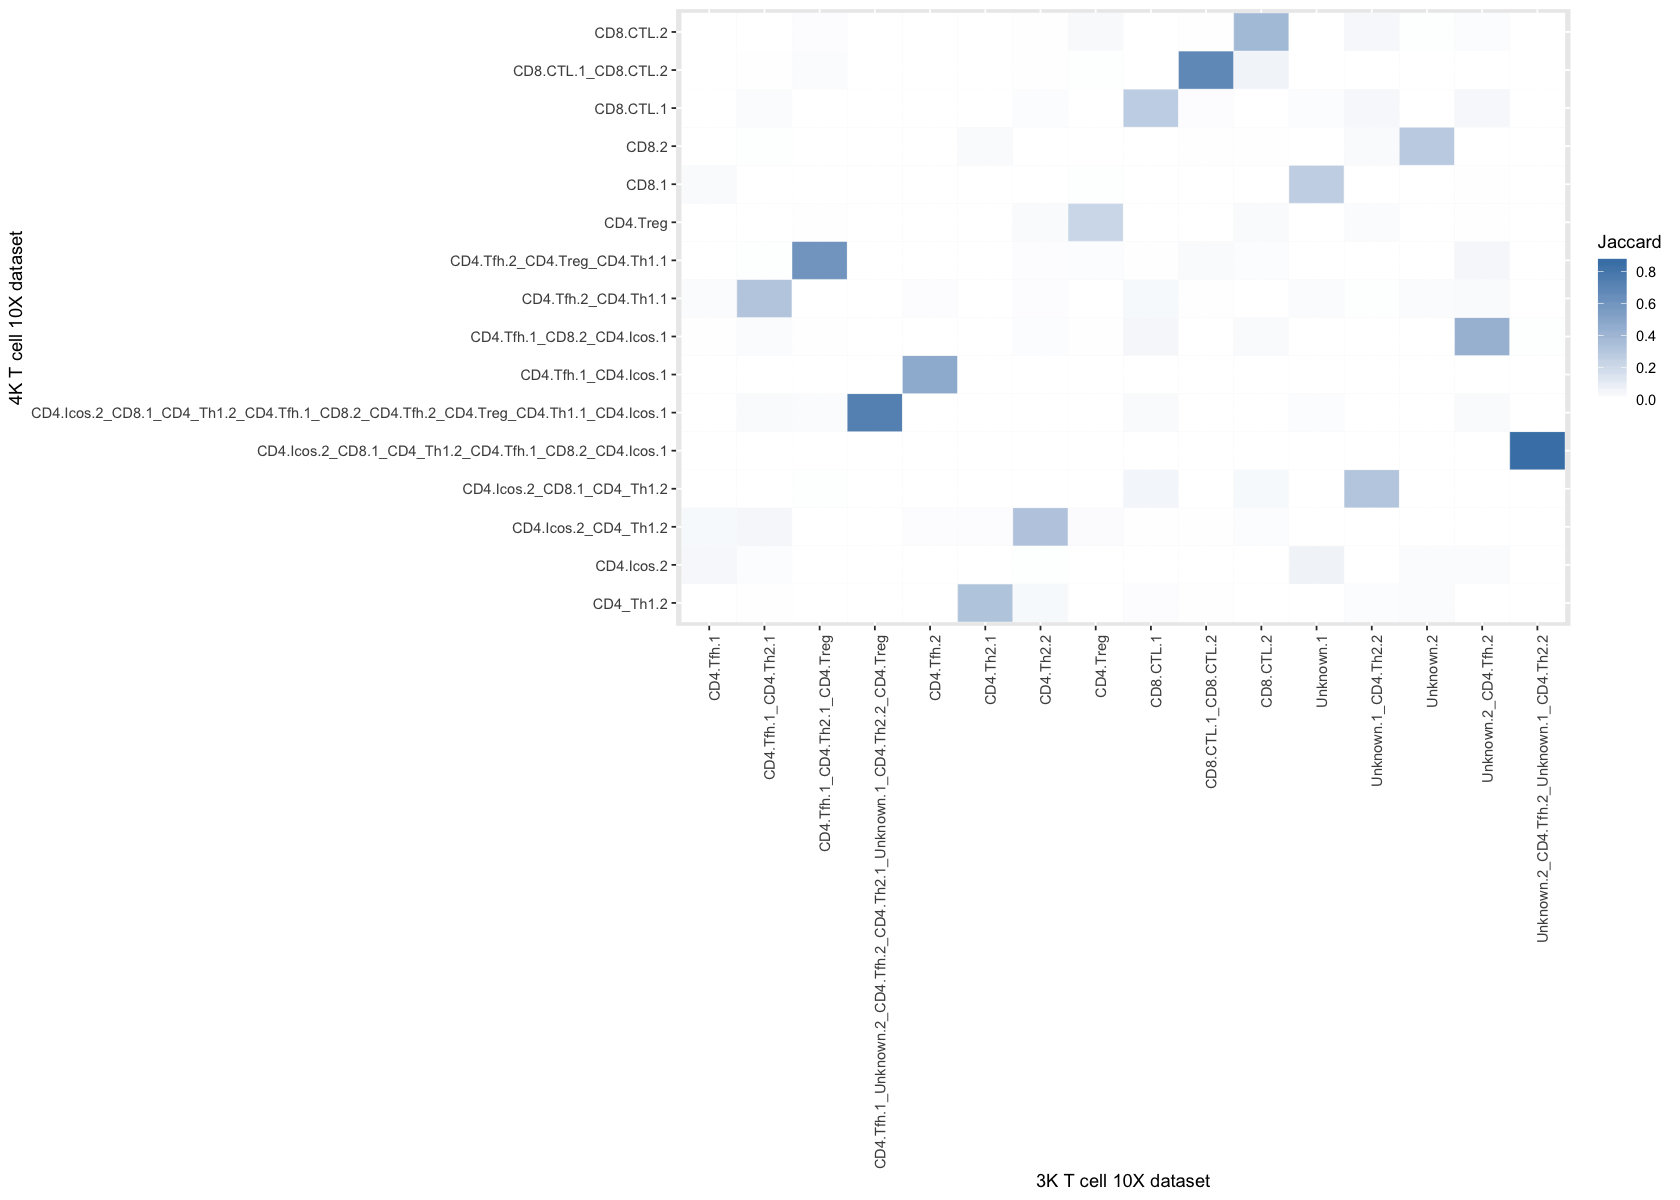

In [130]:
options(repr.plot.width=14, repr.plot.height=10)
p.jaccard

In [131]:
ggsave(p.jaccard, file='../../figures/jaccard_complicated_DE.pdf', width=14, height=10)